let's try to build the dataset from scratch 

important features of the dataset

- the 96 filler sentences are multiplied by 8, since every sentence is spoken by A and B 
- the 48 target sentences are multiplied by 8 because we reuse the same for each cond
- the 6 practice are multiplied by 8 for the same reason

in total that gives 1200 stimuli

The columns we need are the same as theirs
modifications needed: - the answer will not be 3 and 4 but rather 6 and 7 (we can just do +4 for everyone at the end)
not needed, but could shuffle within lists



In [1]:
import pandas as pd
import random
import numpy as np
import warnings

warnings.filterwarnings('ignore')

## Importing files

In [2]:
#useful files
datasource = 'DataSource.csv' #the one in english
fillers_new = 'FrenchFillers.csv'
targets_new = 'TargetFrench.csv'
segmentations = 'SegmentedTargets.csv'

#we will create the dataframe based on their datasource
og_df  = pd.read_csv(datasource) #note: <null> was taken as NaN by python**
fillers_and_practice = pd.read_csv(fillers_new, index_col = False)
fillers = fillers_and_practice[6:]

targets = pd.read_csv(targets_new, header= None, names =[ 'answer', 'paraphrase', 'target' ,'-', '--', '$speech_condition', 'item_id', '$syntactic_condition', '$plausibility_condition',' ', '  ', 'segmented', 'fn','rcv','sn','mc'])
practices = fillers_and_practice[0:6]
practices['i'] = [1,2,3,4,5,6]


#extracting the labels
labels = list(og_df.keys())

labels = ['$sentence_type',
 '$item',
 '$syntactic_condition',
 '$plausibility_condition',
 '$condition',
 '$speech_condition',
 '$drift_picture',
 '$list',
 '$item_number',
 '$section',
 '$picture1',
 '$voice1_description',
 '$picture2',
 '$voice2_description',
 '$paraphrase_validity',
 '$correct_answer',
 '$testitem',
 '$blank_picture',
 '$FN', '$RCV', '$SN', '$MC']

In [3]:
#functions

def pic_name(speaker): #returns the speaker imae filename
    
    if speaker == 'female':
        return 'female_cartoon.png'
    elif speaker == 'male':
        return 'male_cartoon.png'
    elif speaker == 'french':
        return 'french.png'
    elif speaker == 'chinese':
        return 'chinese.png'
    
def get_block(index):
    if index in range(1, 79) or \
       index in range(151, 229) or \
       index in range(301, 379) or \
       index in range(451, 529) or \
       index in range(601, 679) or \
       index in range(751, 829) or \
       index in range(901, 979) or \
       index in range(1051, 1129):
        return 2
    else:
        return 3



In [4]:
#make sure there are no ' ' 
targets['target'] = targets['target'].str.replace("''", "")
targets['target'] = targets['target'].str.replace('"', "")
targets['segmented'] = targets['segmented'].str.replace("''", "")
targets['segmented'] = targets['segmented'].str.replace('"', "")

## Filling practice items in

In [5]:
import random

#make practice speakers list
speech_cond_practice =['female','female','female','male','male','male']
speaker_list = []

for i in range(4):
    random.Random(i).shuffle(speech_cond_practice)
    speaker_list += speech_cond_practice
    
    other_speaker = []
    
    for x in speech_cond_practice:
        if x == 'male':
            other_speaker.append('female')
        elif x == 'female':
            other_speaker.append('male')   
            
    speaker_list += other_speaker
    
len(speaker_list) == 6*8    

True

In [6]:
def get_practice_speakers(i): #where i is the INDEX 
    
    speech_cond_practice =['female','female','female','male','male','male']
    
#list 1 
    #shuffle the list once
    random.shuffle(speech_cond_practice)
    if (i > 0 and i <= 6) or (i >= 300 and i <= 306) or (i >= 600 and i <= 606) or (i > 900 and i <= 906): 
        #block 1
        pic1 = 'female_cartoon.png'
        voice1 = 'practice_female.wav'
        pic2 = 'male_cartoon.png'
        voice2 = 'practice_male.wav'
#list 2 
    elif (i >= 150 and i <= 156) or (i >= 450 and i <= 456) or ( i >= 750 and i <= 756) or (i > 1050 and i <= 1056):
        #block 1
        pic2 = 'female_cartoon.png'
        voice2 = 'practice_female.wav'
        pic1 = 'male_cartoon.png'
        voice1 = 'practice_male.wav'


    return pic1, voice1, pic2, voice2

In [7]:
### PRACTICE ITEMS ###

#the practice items always have the same speakers
def condition_setter(index):
    if index in [1,2,5]:
        return 'female'
    else:
        return 'male'
    
def correct_answer_setter(index):
    if index in [1,2,4]:
        return 7
    else:
        return 6
    
def correct_plausibility_setter(index):
    if index in [0,1,4]:
        return 'plausible'
    else:
        return 'implausible'

practices['condition'] = practices['i'].apply(condition_setter)    
practices['answer'] = practices['i'].apply(correct_answer_setter)    
practices['plausibility'] = practices['i'].apply(correct_plausibility_setter)    

#creating the practice_sentence indices
practice_indices = [1,2,3,4,5,6] + [i+j*150 for i in [1,2,3,4,5,6] for j in [1,2,3,4,5,6,7]]
practice_indices.sort()

In [8]:
#dataframe containing all stimuli
new_df = pd.DataFrame(columns = labels, index = list(range(1,1201)))

In [9]:
for i,n in enumerate(practice_indices):

    #set id item from list
    item_id = int(str(n)[-1])-1 #item number in practice df corresponds to last digit of the index -1 (because of python indexing)
    spkr = speaker_list[i]
    picture1, voice1, picture2, voice2 = get_practice_speakers(n)
    
    new_df.loc[n] = pd.Series({
        '$sentence_type' : 'practice',
        '$item' : practices.loc[item_id, 'french sentence'] ,
        '$condition' : 0,
        '$plausibility_condition' : practices.loc[item_id, 'plausibility']  ,
        '$syntactic_condition' : 'null',
        '$item_number' : 'P'+str(item_id), 
        '$speech_condition' : spkr ,
        '$drift_picture' :  pic_name(spkr),
        '$list' : (n - 1) // 150 + 1, #list from 1 to 8
        '$section' : 1,
        '$picture1' : picture1, #for the pres of the char, fem always first in practice round
        '$voice1_description' :  voice1, #*************might need to change this
        '$picture2' : picture2,
        '$voice2_description' : voice2,
        '$paraphrase_validity' : practices.loc[item_id, 'french paraphrase'] ,
        '$correct_answer' : practices.loc[item_id, 'answer'] ,
        '$testitem' : 'no',
        '$blank_picture' : 'blank.png',
        '$FN': 0,
        '$RCV': 0,
        '$SN': 0,
        '$MC': 0})

In [10]:
len(new_df[new_df['$sentence_type'] == 'practice'])

48

## Filling Target sentences in

In [11]:
#shuffle everything s.t. every set of 24 has 6 sentences of each condition
df = targets

# Step 2: Define the function to shuffle and interleave sub-blocks
def shuffle_and_interleave(df, block_size=48, sub_block_size=12, mini_block_size=6):
    blocks = [df.iloc[i:i + block_size] for i in range(0, len(df), block_size)]
    
    all_sub_blocks = []
    for block in blocks:
        # Split the block into sub-blocks of 12 rows
        sub_blocks = [block.iloc[i:i + sub_block_size] for i in range(0, block_size, sub_block_size)]
        # Further split each 12-row sub-block into 6-row mini-blocks
        mini_blocks = [sub_block.iloc[i:i + mini_block_size] for sub_block in sub_blocks for i in range(0, sub_block_size, mini_block_size)]

        # Interleave the mini-blocks
        interleaved = []
        for i in [0,2,4,6]:
            interleaved.append(mini_blocks[i])
        for i in [1,3,5,7]:
            interleaved.append(mini_blocks[i])
            
        all_interleaved_mini_blocks = pd.concat(interleaved).reset_index(drop=True)
        all_sub_blocks.append(all_interleaved_mini_blocks)

    # Concatenate the interleaved mini-blocks back into a single DataFrame
    result = pd.concat(all_sub_blocks).reset_index(drop=True)
    return result

# Step 3: Apply the shuffling and interleaving function to the DataFrame
result = shuffle_and_interleave(df)

#assign df to targets
shuffled_targets=result

In [12]:
len(shuffled_targets)

384

In [13]:
#only need every 1st 48 item list and we duplicate it
# Function to extract every half block from a DataFrame
df = shuffled_targets
def extract_half_blocks(df, block_size=96, half_block_size=48):
    blocks = [df.iloc[i:i + block_size] for i in range(0, len(df), block_size)]
    half_blocks = []
    
    for block in blocks:
        if len(block) == block_size:
            # Extract first half and second half of the block
            first_half = block.iloc[:half_block_size]
            second_half = block.iloc[half_block_size:]
            half_blocks.append(first_half)
            half_blocks.append(first_half)
    
    # Concatenate all the extracted half-blocks
    result = pd.concat(half_blocks).reset_index(drop=True)
    return result

# Extract every half block
result = extract_half_blocks(df)

#assign df to targets
targets = result

In [14]:
#creating the target_sentence indices, they are placed every 3 indices
target_indices =  [i+j*150 for i in np.arange(7,150,3) for j in [0,1,2,3,4,5,6,7]]
target_indices.sort()


#creating the even lists index list to change the speaker
even_lists = [np.arange(48, 96)*i for i in [1,2,3,4]]

list_even = []

for sublist in even_lists:
    for i in sublist:
        list_even.append(i)
    
len(list_even)
len(list_even[:48])
len(list_even)

192

In [15]:
speakers_2lists = ['french','french','french','chinese','chinese','chinese']*8  + ['chinese','chinese','chinese','french','french','french']*8
speakers_all = 4* speakers_2lists
len(speakers_all)

384

In [16]:
def syntactic_condition_setter(stype):
    if stype == 'SRC':
        return 'subject'
    elif stype == 'ORC':
        return 'object'
    
def rowIndex(row):
    return row.name

targets['$speech_condition'] = speakers_all
targets['row_index'] = targets.apply(rowIndex, axis=1)
targets['$syntactic_condition'] = targets['$syntactic_condition'].apply(syntactic_condition_setter)    

In [17]:
targets['$speech_condition']

0       french
1       french
2       french
3      chinese
4      chinese
        ...   
379    chinese
380    chinese
381     french
382     french
383     french
Name: $speech_condition, Length: 384, dtype: object

In [18]:
def get_beginning_texts(index):
#list 1 
    if i > 1 and i <= 78: 
        #block 1
        pic1 = 'chinese.png'
        voice1 = 'chinese2.wav'
        pic2 = 'french.png'
        voice2 = 'french1.wav'
    elif i > 78 and i <= 150:
        #block 2
        pic1 = 'french.png'
        voice1 = 'french3.wav'
        pic2 = 'chinese.png'
        voice2 = 'chinese4.png'
#list 2 
    elif i > 150 and i <= 228:
        #block 1
        pic1 = 'chinese.png'
        voice1 = 'chinese1.wav'
        pic2 = 'french.png'
        voice2 = 'french2.wav'
    elif i > 228 and i <= 300:
        #block 2
        pic1 = 'french.png'
        voice1 = 'french4.wav'
        pic2 = 'chinese.png'
        voice2 = 'chinese3.wav'
#list 3 
    elif i > 300 and i < 378:
        #block1
        pic1 = 'french.png'
        voice1 = 'french4.wav'
        pic2 = 'chinese.png'
        voice2 = 'chinese3.wav'
    elif i > 378 and i <= 450:
        #block 2
        pic1 = 'chinese.png'
        voice1 = 'chinese1.wav'
        pic2 = 'french.png'
        voice2 = 'french2.wav'
#list 4 
    elif i > 450 and i <= 528:
        #block 1
        pic1 = 'french.png'
        voice1 = 'french3.wav'
        pic2 = 'chinese.png'
        voice2 = 'chinese4.wav'
    elif i > 528 and i <= 600:
        #block 2
        pic1 = 'chinese.png'
        voice1 = 'chinese2.wav'
        pic2 = 'french.png'
        voice2 = 'french1.wav'
#list 5
    elif i > 600 and i <= 678:
        #block 1
        pic1 = 'french.png'
        voice1 = 'french3.wav'
        pic2 = 'chinese.png'
        voice2 = 'chinese4.wav'
    elif i > 678 and i <= 750:
        #block 2
        pic1 = 'chinese.png'
        voice1 = 'chinese2.wav'
        pic2 = 'french.png'
        voice2 = 'french1.wav'
#list 6 
    elif i > 750 and i <= 828:
        #block 1
        pic1 = 'french.png'
        voice1 = 'french4.wav'
        pic2 = 'chinese.png'
        voice2 = 'chinese3.wav'
    elif i > 828 and i <= 900:
        #block 2
        pic1 = 'chinese.png'
        voice1 = 'chinese1.wav'
        pic2 = 'french.png'
        voice2 = 'french2.wav'
#list 7 
    elif i > 900 and i <= 978:
        #block 1
        pic1 = 'chinese.png'
        voice1 = 'chinese1.wav'
        pic2 = 'french.png'
        voice2 = 'french2.wav'
    elif i > 978 and i <= 1050:
        #block 2
        pic1 = 'french.png'
        voice1 = 'french4.wav'
        pic2 = 'chinese.png'
        voice2 = 'chinese3.wav'
#list 8 
    elif i > 1050 and i <= 1128:
        #block 1
        pic1 = 'chinese.png'
        voice1 = 'chinese2.wav'
        pic2 = 'french.png'
        voice2 = 'french1.wav'
    elif i > 1128 and i <= 1200:
        #block 2
        pic1 = 'french.png'
        voice1 = 'french3.wav'
        pic2 = 'chinese.png'
        voice2 = 'chinese4.png'
        
    return pic1, voice1, pic2, voice2

In [19]:
for n, i  in enumerate(target_indices): #the indices are given by i, n is the nth index
    
    #set id item from list
    item_id = n
    spkr = targets.loc[item_id, '$speech_condition']

    
    new_df.loc[i] = pd.Series({
        '$sentence_type' : 'target',
        '$item' : targets.loc[item_id, 'segmented'] ,
        '$plausibility_condition' : targets.loc[item_id, '$plausibility_condition'],
        '$syntactic_condition' : targets.loc[item_id, '$syntactic_condition'],
        '$speech_condition' : spkr ,
        '$drift_picture' :  pic_name(spkr),
        '$item_number' : targets.loc[item_id, 'item_id'], 
        '$list' : (i - 1) // 150 + 1, #list from 1 to 8
        '$section' : get_block(i),
        '$paraphrase_validity' : targets.loc[item_id, 'paraphrase'] ,
        '$correct_answer' : 6 , #they are all correct
        '$testitem' : 'yes',
        '$blank_picture' : 'blank.png',
        '$FN': targets.loc[item_id, 'fn'],
        '$RCV': targets.loc[item_id, 'rcv'],
        '$SN': targets.loc[item_id, 'sn'],
        '$MC': targets.loc[item_id, 'mc'] })
    

## Finally, the fillers

In [22]:
#correcting the msitakes in the og df
og_df['$item'] = og_df['$item'].str.replace('serous', 'serious')

In [23]:
len(fillers)/2

48.0

In [24]:
### getting some informations from the original df

In [25]:
#creating the filler_sentence indices
test_indices = [i+j*150 for i in np.arange(7,151) for j in [0,1,2,3,4,5,6,7]]
filler_indices = list(set(test_indices).difference(target_indices))
filler_indices.sort()
filler_indices[-1] 

fillers = fillers.replace('. ', '.') #remove all spaces after point in sentences
fillers['english sentence'] = fillers['english sentence'].str.replace("'", "")

In [26]:
#go get correct answers in the og_df 
for i, row in fillers.iterrows():
    english_sentence = row['english sentence']
    correct_answer = og_df.loc[og_df['$item'] == english_sentence, '$correct_answer'].iloc[0]
    plausibility = og_df.loc[og_df['$item'] == english_sentence, '$plausibility_condition'].iloc[0]
    fillers.at[i, 'answer'] = correct_answer 
    fillers.at[i, 'plausibility'] = plausibility

In [27]:
#need to duplicate the fillers
duplicated_fillers = pd.concat([fillers] * 8, ignore_index=True)

In [28]:
#setting the drift pictures for the fillers

#it must be alternating between list 1 & 2, 3&4 .. 
#it must be counter balanced

#randomly assign the speech condition for the original list
def create_speaker_lists(random_seed): #fct that creates a random list of speakers
    filler_speaker_list = ['french.png']*48 + ['chinese.png']*48
    random.seed(random_seed)
    random.shuffle(filler_speaker_list)
    
    opposite_speaker_list = []
    for item in filler_speaker_list:
        if item == 'french.png':
            opposite_speaker_list.append('chinese.png')
        if item == 'chinese.png':
            opposite_speaker_list.append('french.png')

            
    return list(filler_speaker_list), list(opposite_speaker_list)

list1,list2 = create_speaker_lists(1)
list3,list4 = create_speaker_lists(2)
list5,list6 = create_speaker_lists(3)
list7,list8 = create_speaker_lists(4)

filler_speakers_list = list1+list2+list3+list4+list5+list6+list7+list8

In [29]:
#filling up the new df
for n, i  in enumerate(filler_indices): #the indices are given by i, n is the nth index
    #set id item from list
    item_id = n#the indices are shifted by 6
    spkr =  filler_speakers_list[n]
    
    new_df.loc[i] = pd.Series({
        '$sentence_type' : 'filler',
        '$item' : duplicated_fillers.loc[item_id, 'french sentence'] ,
        '$plausibility_condition' : duplicated_fillers.loc[item_id, 'plausibility'],
        '$syntactic_condition' : 'none',
        '$item_number' : 'F' + str(n), 
        '$list' : (i - 1) // 150 + 1, #list from 1 to 8
        '$speech_condition': spkr[:-4],
        '$drift_picture': spkr,
        '$section' : get_block(i),
        '$paraphrase_validity' : duplicated_fillers.loc[item_id, 'french paraphrase'] ,
        '$correct_answer' : int(duplicated_fillers.loc[item_id, 'answer']), 
        '$testitem' : 'yes',
        '$blank_picture' : 'blank.png',
        '$FN': 0,
        '$RCV': 0,
        '$SN': 0,
        '$MC': 0})

## Last tweaks

In [30]:
#dont forget to take care of '' '' at the end
new_df = new_df.replace('. ', '.') #remove all spaces after point in sentences
new_df['$item'] = new_df['$item'] .apply(lambda x: '« ' + x + ' »')

In [31]:
#setting the condition column
def set_condition(sentence_type, syntactic_cond, plausibility_cond):
    if sentence_type == 'practice':
        return 0
    elif syntactic_cond == 'subject' and plausibility_cond == 'plausible':
        return 1
    elif syntactic_cond == 'subject' and plausibility_cond == 'implausible':
        return 2
    elif syntactic_cond == 'object' and plausibility_cond == 'plausible':
        return 3
    elif syntactic_cond == 'object' and plausibility_cond == 'implausible':
        return 4
    elif syntactic_cond == 'none' and plausibility_cond == 'implausible':
        return 5    
    elif syntactic_cond == 'none' and plausibility_cond == 'plausible':
        return 6
    
    
new_df['$condition'] = new_df.apply(lambda row: set_condition(row['$sentence_type'], row['$syntactic_condition'], row['$plausibility_condition']), axis=1)

In [32]:
#must set the voices 1 and 2
def set_text_speakers(list_nb, section): #returns the pic1, voice1, pic2 and voice2 values
    if list_nb == 1 and section == 2 : #section1 block1 is their 1st
        return ['chinese.png', 'chinese2.wav', 'french.png', 'french1.wav']
    if list_nb == 1 and section == 3: #section1 block 2
        return 'french.png', 'french3.wav', 'chinese.png', 'chinese4.wav'
    
    if list_nb == 2 and section == 2: #section2 block 1
        return 'french.png', 'french4.wav', 'chinese.png', 'chinese3.wav'
    if list_nb == 2 and section == 3:
        return 'chinese.png', 'chinese1.wav', 'french.png', 'french2.wav'
    
    if list_nb == 3 and section == 2: #section2 block 1
        return 'french.png', 'french3.wav', 'chinese.png', 'chinese4.wav'
    if list_nb == 3 and section == 3:
        return 'chinese.png', 'chinese2.wav', 'french.png', 'french1.wav'
    
    if list_nb == 4 and section == 2 : #section1 block1 is their 1st
            return 'chinese.png', 'chinese1.wav', 'french.png', 'french2.wav'
    if list_nb == 4 and section == 3: #section1 block 2
        return 'french.png', 'french4.wav', 'chinese.png', 'chinese3.wav'
    
    if list_nb == 5 and section == 2 : #section1 block1 is their 1st
            return 'chinese.png', 'chinese1.wav', 'french.png', 'french2.wav'
    if list_nb == 5 and section == 3: #section1 block 2
        return 'french.png', 'french4.wav', 'chinese.png', 'chinese3.wav'
    
    if list_nb == 6 and section == 2 : #section1 block1 is their 1st
            return 'french.png', 'french3.wav', 'chinese.png', 'chinese4.wav'
    if list_nb == 6 and section == 3: #section1 block 2
        return 'chinese.png', 'chinese2.wav', 'french.png', 'french1.wav'
    
    if list_nb == 7 and section == 2 : #section1 block1 is their 1st
            return 'french.png', 'french4.wav', 'chinese.png', 'chinese3.wav'
    if list_nb == 7 and section == 3: #section1 block 2
        return 'chinese.png', 'chinese1.wav', 'french.png', 'french2.wav'
    
    if list_nb == 8 and section == 2 : #section1 block1 is their 1st
            return  'chinese.png', 'chinese2.wav', 'french.png', 'french1.wav'
    if list_nb == 8 and section == 3: #section1 block 2
        return 'french.png', 'french3.wav', 'chinese.png', 'chinese4.wav'
    else:
        return 'female_cartoon.png','practice_female_description.wav','male_cartoon.png','practice_male_description.wav'

new_df[['$picture1', '$voice1_description', '$picture2', '$voice2_description']] = new_df.apply(lambda row: pd.Series(set_text_speakers(row['$list'], row['$section'])), axis=1, result_type='expand')

In [33]:
print(len(new_df[new_df['$section'] == 1]) == 8*6)
print(len(new_df[new_df['$section'] == 2]) == 8*72)
print(len(new_df[new_df['$section'] == 3]) == 8*72)

True
True
True


In [34]:
# convert the 6 to 3 and 7 to 4:
new_df['$correct_answer']= new_df['$correct_answer'].sub(3)

In [36]:
new_df.keys()

Index(['$sentence_type', '$item', '$syntactic_condition',
       '$plausibility_condition', '$condition', '$speech_condition',
       '$drift_picture', '$list', '$item_number', '$section', '$picture1',
       '$voice1_description', '$picture2', '$voice2_description',
       '$paraphrase_validity', '$correct_answer', '$testitem',
       '$blank_picture', '$FN', '$RCV', '$SN', '$MC'],
      dtype='object')

In [47]:
new_df[(new_df['$list'] == 2) & (new_df['$condition'] == 1) &  (new_df['$speech_condition'] == 'french')].count()

$sentence_type             6
$item                      6
$syntactic_condition       6
$plausibility_condition    6
$condition                 6
$speech_condition          6
$drift_picture             6
$list                      6
$item_number               6
$section                   6
$picture1                  6
$voice1_description        6
$picture2                  6
$voice2_description        6
$paraphrase_validity       6
$correct_answer            6
$testitem                  6
$blank_picture             6
$FN                        6
$RCV                       6
$SN                        6
$MC                        6
dtype: int64

In [44]:
new_df[(new_df['$list'] == 1) & (new_df['$speech_condition'] == 'french') ].count()

$sentence_type             72
$item                      72
$syntactic_condition       72
$plausibility_condition    72
$condition                 72
$speech_condition          72
$drift_picture             72
$list                      72
$item_number               72
$section                   72
$picture1                  72
$voice1_description        72
$picture2                  72
$voice2_description        72
$paraphrase_validity       72
$correct_answer            72
$testitem                  72
$blank_picture             72
$FN                        72
$RCV                       72
$SN                        72
$MC                        72
dtype: int64

In [33]:
new_df.to_csv('French_DataSource.csv', header= True, index = False, encoding='latin1')

## No speaker version

In [34]:
#and now the no speaker version
#we can remove the drift image and speaker columns
no_spkr_df = new_df.drop(['$drift_picture', '$picture1',
                          '$voice1_description', '$picture2', 
                          '$voice2_description' ,'$speech_condition'], axis = 1)

no_spkr_df = no_spkr_df[no_spkr_df['$list']%2 == 1] #keeping only every two list

In [35]:
#remove guillemets
no_spkr_df['$item'] = no_spkr_df['$item'] .str.replace("«", "")
no_spkr_df['$item'] = no_spkr_df['$item'] .str.replace("»", "")
no_spkr_df['$item'] = no_spkr_df['$item'] .str.replace("\xa0", "")

In [36]:
no_spkr_df.to_csv('NoSpeaker_French_DataSource.csv', header= True, index = False, encoding='latin1')

In [38]:
no_spkr_df.keys()

Index(['$sentence_type', '$item', '$syntactic_condition',
       '$plausibility_condition', '$condition', '$list', '$item_number',
       '$section', '$paraphrase_validity', '$correct_answer', '$testitem',
       '$blank_picture', '$FN', '$RCV', '$SN', '$MC'],
      dtype='object')

#may be useful
def speech_condition_setter(file):
    if LIST in list_odd:
        
    
def speech_condition_switcher(LIST,speaker): #switch every second
    if LIST in list_even:
        if speaker == 'chinese':
            return 'french'
        elif speaker == 'french':
                return 'chinese'
    return speaker #if not in an even list

In [78]:
#verifying the results file 
import csv 

test_file = ["E:/APS exp/no_speaker_source_code_french_version/results/Test2/RESULTS_FILE.txt"]

test_keys = list(pd.read_csv(test_file[0],delimiter = '\t').keys())

test_data = []
for file in test_file:
    data_file = open(file, "r",encoding = 'utf-8')
    data = list(csv.reader(data_file, delimiter="\t"))[1:] #skipping header
    data_file.close()
    test_data += data

    
test_df2 = pd.DataFrame(test_data, columns = test_keys)

<AxesSubplot:>

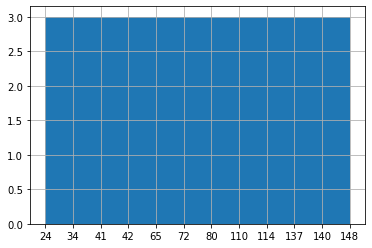

In [79]:
test_df2[test_df2.condition == '4']['Trial_Index_'].hist(bins = 4)

In [81]:
test_df2.loc[test_df2.sentence_type == 'target',['Trial_Index_','condition']].head(96)

,Trial_Index_,condition
9,10,2
10,11,2
11,12,1
12,13,3
15,16,1
17,18,3
18,19,3
23,24,4
29,30,1
33,34,4


In [77]:
test_df.loc[test_df.sentence_type == 'target',['Trial_Index_','condition']].head(96)

,Trial_Index_,condition
6,7,4
9,10,2
20,21,2
21,22,1
26,27,1
27,28,4
30,31,3
33,34,3
36,37,3
37,38,3
